# E-commerce Fraud Detection System
## Wildberries & Flip.kz Marketplace Analysis

**Dataset:** 5.863 products from WB and Flip.kz

**Goal:** Detect fraudulent sellers and products using ML classification and clustering

---
## Setup & Data Loading
---

In [55]:
# Total imports 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve, precision_recall_curve,
    confusion_matrix, classification_report
)
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)
plt.style.use('default')
sns.set_palette('husl')

In [56]:
# Load dataset
df = pd.read_csv('./all_product2.csv') 
print(f"Dataset: {df.shape[0]:,} rows × {df.shape[1]} columns")
print(f"\nColumns: {df.columns.tolist()}")

# Show first 10 samples
df.head(10)

Dataset: 5,862 rows × 15 columns

Columns: ['name', 'brand', 'price_rub', 'price_kzt', 'seller', 'seller_id', 'seller_rating', 'seller_total_sold', 'seller_age_months', 'feedbacks', 'category', 'source_file', 'risk_level', 'publication_date', 'first_review_datetime']


,name,brand,price_rub,price_kzt,seller,seller_id,seller_rating,seller_total_sold,seller_age_months,feedbacks,category,source_file,risk_level,publication_date,first_review_datetime
0,Умный тренажёр для ног бедер ягодиц,Q,846.0,5076.0,ВсёМаркет,250046174.0,4.3,0.0,28.0,0.0,тренажеры,all_products.csv,medium,2024-07-03,2024-07-10
1,Тренажер для спины и поясницы,NaN,430.0,2580.0,Sheikh,250001281.0,4.6,0.0,12.0,0.0,тренажеры,all_products.csv,low,2025-04-26,2025-05-06
2,Универсальный тренажёр Эспандер,АТМ95,798.0,4788.0,MERI,250079034.0,4.7,0.0,22.0,0.0,тренажеры,all_products.csv,low,2025-05-07,2025-05-24
3,Степпер тренажер для ног бедер и ягодиц с эспа...,EnergyFit,5008.0,30048.0,EnergyFit,4413375.0,4.9,58776.0,35.0,5937.0,тренажеры,all_products.csv,low,2023-09-25,2023-10-11
4,Металлический диск для коррекции фигуры,NaN,612.0,3672.0,BRB SHOP,250075919.0,4.7,0.0,18.0,0.0,диски для скольжения,all_products.csv,low,2025-04-30,2025-05-13
5,"Набор фитнес резинок, ленточный тренажер от 3-...",AleksTeam,959.0,5754.0,AleksTeam,1358048.0,4.6,0.0,38.0,0.0,тренажеры,all_products.csv,low,2024-09-10,2024-09-16
6,Тренажер степпер для дома,NaN,3214.0,19284.0,AGEEVA,3958712.0,4.6,0.0,47.0,0.0,тренажеры,all_products.csv,low,2024-08-04,2024-08-07
7,Виброплатформа Shake Black фитнес тренажер плю...,GESS,7041.0,42246.0,REAL PRICE,250076008.0,4.7,0.0,42.0,0.0,тренажеры,all_products.csv,low,2023-08-09,2023-08-13
8,Фитнес твистер с резинками тренажёр для ягодиц...,ATS2,990.0,5940.0,LaraMix,250044203.0,4.5,0.0,8.0,0.0,тренажеры,all_products.csv,low,2025-06-01,2025-06-11
9,Диск здоровья вращающийся с эспандерами для по...,TIDDO,989.0,5934.0,Мелочи для дома,250032597.0,4.5,0.0,13.0,0.0,тренажеры,all_products.csv,low,2025-10-09,2025-10-20


In [57]:
# Data overview --> Unique nums
print("\n" + "="*60)
print("DATA OVERVIEW")
print("="*60)
print(f"\nTotal products: {len(df):,}")
print(f"Unique sellers: {df['seller_id'].nunique():,}")
print(f"Categories: {df['category'].nunique():,}")
print(f"Sources: {df['source_file'].unique().tolist()}")

print("\n" + "="*60)
print("MISSING DATA")
print("="*60)
missing = df.isnull().sum()
missing_pct = (missing / len(df)) * 100
missing_df = pd.DataFrame({
    'Missing': missing[missing > 0],
    'Percent': missing_pct[missing > 0]
}).sort_values('Percent', ascending=False)
print(missing_df)


DATA OVERVIEW

Total products: 5,862
Unique sellers: 2,578
Categories: 156
Sources: ['all_products.csv', 'flip_fraud_dataset_filled_v2.csv', 'flip_fraud_dataset_fixed.csv']

MISSING DATA
           Missing    Percent
seller_id     1997  34.066871
brand          869  14.824292


---
## Fraud Label Creation
---

In [58]:
# Create fraud detection features
df_fraud = df.copy()

print("\n" + "="*60)
print("FRAUD INDICATORS CREATION")
print("="*60)

# Calculate price z-scores by category
category_stats = df_fraud.groupby('category')['price_rub'].agg(['mean', 'std']).reset_index() # grouping by cat
category_stats.columns = ['category', 'cat_mean', 'cat_std']
df_fraud = df_fraud.merge(category_stats, on='category', how='left')
df_fraud['price_zscore'] = np.abs((df_fraud['price_rub'] - df_fraud['cat_mean']) / (df_fraud['cat_std'] + 1)) # we work with category, so added prefix 'cat'

print("\nSample fraud indicators:")
print(df_fraud[['category', 'price_rub', 'price_zscore']].head(10))



FRAUD INDICATORS CREATION

Sample fraud indicators:
               category  price_rub  price_zscore
0             тренажеры      846.0      0.499615
1             тренажеры      430.0      0.671244
2             тренажеры      798.0      0.519418
3             тренажеры     5008.0      1.217500
4  диски для скольжения      612.0      0.856486
5             тренажеры      959.0      0.452994
6             тренажеры     3214.0      0.477350
7             тренажеры     7041.0      2.056254
8             тренажеры      990.0      0.440205
9             тренажеры      989.0      0.440617


In [59]:
# 1. FAKE REVIEWS INDICATOR
df_fraud['is_fake_reviews'] = 0

if df_fraud['feedbacks'].notna().sum() > 0 and df_fraud['feedbacks'].max() > 0:
    feedback_high = df_fraud['feedbacks'].quantile(0.9) 
    age_young = 6  # months 
    
    df_fraud['is_fake_reviews'] = (
        # Many reviews + very new seller
        ((df_fraud['feedbacks'] > feedback_high) & 
         (df_fraud['seller_age_months'] < age_young)) |
        # Many reviews + terrible rating
        ((df_fraud['feedbacks'] > df_fraud['feedbacks'].median()) & 
         (df_fraud['seller_rating'] < 3.5))
    ).astype(int) # True / False ===> 1/0

print(f"\n1. Fake Reviews: {df_fraud['is_fake_reviews'].sum():,} ({df_fraud['is_fake_reviews'].mean()*100:.2f}%)")
print(f"   Logic: High reviews + new seller OR high reviews + low rating")


1. Fake Reviews: 18 (0.31%)
   Logic: High reviews + new seller OR high reviews + low rating


In [60]:
# 2. FRAUD SELLER (MAIN TARGET)
# using independent values instead of creating threshold which ruins ml data
AGE_THRESHOLD = 6  
SALES_THRESHOLD = 10 
FEEDBACK_THRESHOLD = 5  

df_fraud['is_fraud_seller'] = (
    # suspicious behavior 1
    ((df_fraud['seller_age_months'] < AGE_THRESHOLD) & 
     (df_fraud['seller_total_sold'] < SALES_THRESHOLD)) |
    
    # suspicious behavior 2
    ((df_fraud['seller_total_sold'] > 0) & 
     (df_fraud['feedbacks'] == 0)) |
    
    # suspicious behavior 3
    (df_fraud['price_zscore'].abs() > 3)
).astype(int)

print(f"\n2. Fraud Seller (MAIN): {df_fraud['is_fraud_seller'].sum():,} ({df_fraud['is_fraud_seller'].mean()*100:.2f}%)")
print(f"   Logic: (age<{AGE_THRESHOLD}mo & sales<{SALES_THRESHOLD}) OR (sales>0 & feedbacks=0) OR |price_zscore|>3")


2. Fraud Seller (MAIN): 372 (6.35%)
   Logic: (age<6mo & sales<10) OR (sales>0 & feedbacks=0) OR |price_zscore|>3


In [61]:
# 3. LOW QUALITY INDICATOR
df_fraud['is_low_quality'] = 0

if df_fraud['feedbacks'].notna().sum() > 0 and df_fraud['feedbacks'].max() > 0:
    feedback_median = df_fraud['feedbacks'].median()
    
    df_fraud['is_low_quality'] = (
        (df_fraud['seller_rating'] < 4.0) & 
        (df_fraud['feedbacks'] > feedback_median)
    ).astype(int)

print(f"\n3. Low Quality: {df_fraud['is_low_quality'].sum():,} ({df_fraud['is_low_quality'].mean()*100:.2f}%)")
print(f"   Logic: rating < 4.0 + many feedbacks (proven bad quality)")


3. Low Quality: 360 (6.14%)
   Logic: rating < 4.0 + many feedbacks (proven bad quality)


In [62]:
# 4. PRICE MANIPULATION
ZSCORE_THRESHOLD = 3

df_fraud['is_price_manipulation'] = (
    df_fraud['price_zscore'] > ZSCORE_THRESHOLD
).astype(int)

print(f"\n4. Price Manipulation: {df_fraud['is_price_manipulation'].sum():,} ({df_fraud['is_price_manipulation'].mean()*100:.2f}%)")
print(f"   Logic: price z-score > {ZSCORE_THRESHOLD} (extreme outlier)")


4. Price Manipulation: 89 (1.52%)
   Logic: price z-score > 3 (extreme outlier)


In [63]:
# 5. FRAUD SCORE (0-100)
df_fraud['fraud_score'] = (
    df_fraud['is_fake_reviews'] * 15 +
    df_fraud['is_fraud_seller'] * 50 +      # Most important
    df_fraud['is_low_quality'] * 15 +
    df_fraud['is_price_manipulation'] * 20
)

print(f"\n5. Fraud Score: mean={df_fraud['fraud_score'].mean():.1f}, max={df_fraud['fraud_score'].max():.0f}")
print(f"   Logic: Weighted composite (fake_reviews:15 + fraud_seller:50 + low_quality:15 + price:20)")

print("\n" + "="*60)
print("FRAUD DISTRIBUTION")
print("="*60)
print(df_fraud['is_fraud_seller'].value_counts())
print(f"\nFraud rate: {df_fraud['is_fraud_seller'].mean()*100:.2f}%")


5. Fraud Score: mean=4.4, max=70
   Logic: Weighted composite (fake_reviews:15 + fraud_seller:50 + low_quality:15 + price:20)

FRAUD DISTRIBUTION
is_fraud_seller
0    5490
1     372
Name: count, dtype: int64

Fraud rate: 6.35%


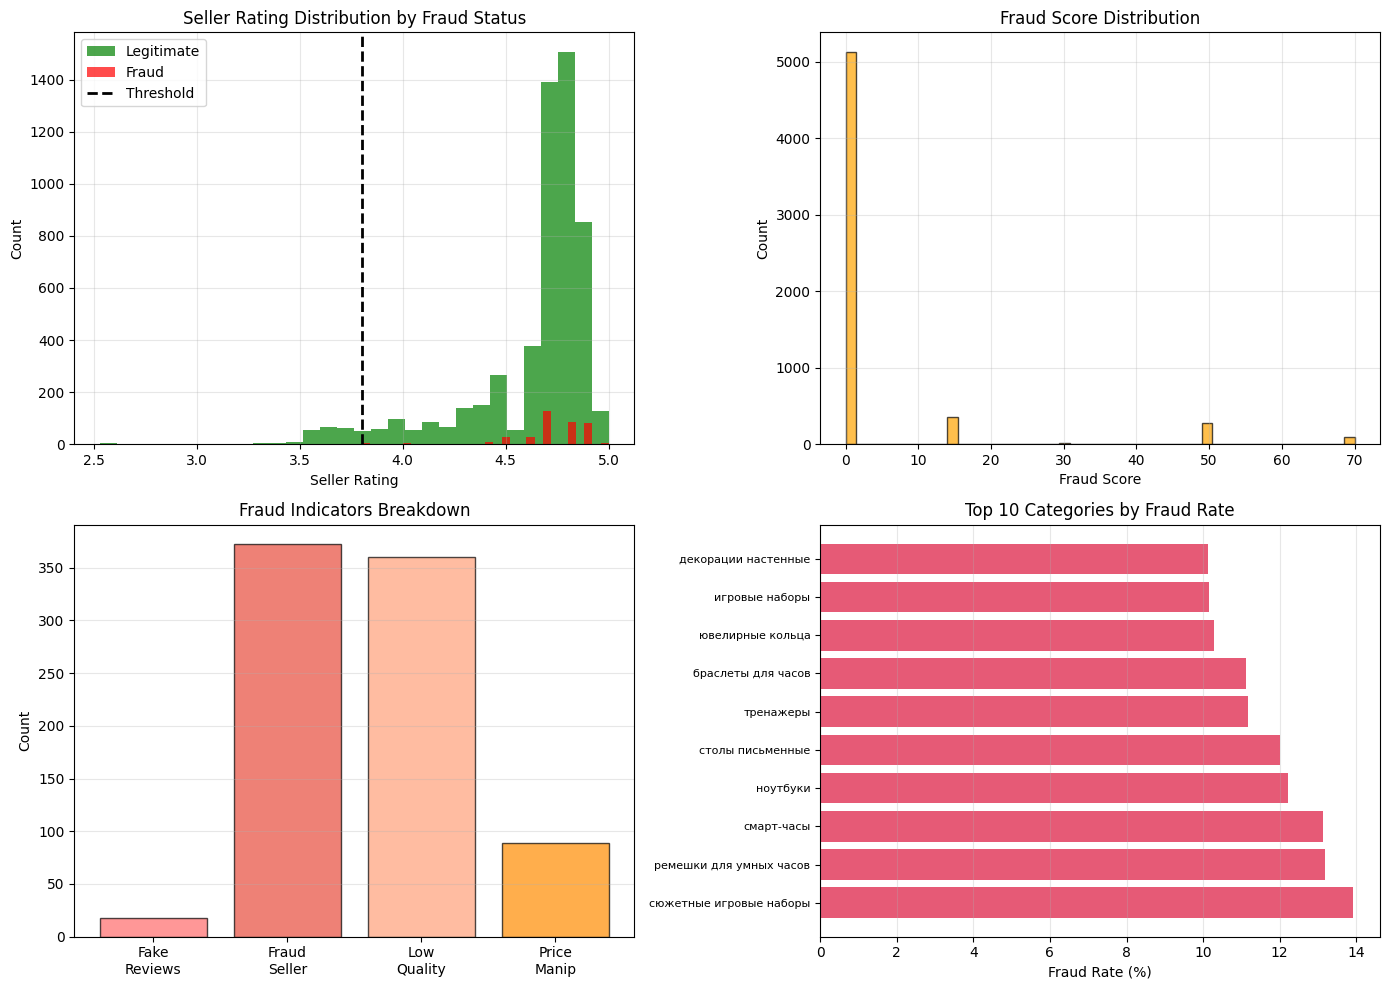

In [64]:
# Visualize fraud indicators
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Seller rating distribution
axes[0,0].hist(df_fraud[df_fraud['is_fraud_seller']==0]['seller_rating'], 
               bins=30, alpha=0.7, label='Legitimate', color='green')
axes[0,0].hist(df_fraud[df_fraud['is_fraud_seller']==1]['seller_rating'], 
               bins=30, alpha=0.7, label='Fraud', color='red')
axes[0,0].axvline(RATING_THRESHOLD, color='black', linestyle='--', linewidth=2, label='Threshold')
axes[0,0].set_xlabel('Seller Rating')
axes[0,0].set_ylabel('Count')
axes[0,0].set_title('Seller Rating Distribution by Fraud Status')
axes[0,0].legend()
axes[0,0].grid(True, alpha=0.3)

# 2. Fraud score distribution
axes[0,1].hist(df_fraud['fraud_score'], bins=50, color='orange', alpha=0.7, edgecolor='black')
axes[0,1].set_xlabel('Fraud Score')
axes[0,1].set_ylabel('Count')
axes[0,1].set_title('Fraud Score Distribution')
axes[0,1].grid(True, alpha=0.3)

# 3. Fraud indicators breakdown
indicators = ['is_fake_reviews', 'is_fraud_seller', 'is_low_quality', 'is_price_manipulation']
counts = [df_fraud[col].sum() for col in indicators]
labels = ['Fake\nReviews', 'Fraud\nSeller', 'Low\nQuality', 'Price\nManip']
colors = ['#FF6B6B', '#E74C3C', '#FFA07A', '#FF8C00']
axes[1,0].bar(labels, counts, color=colors, alpha=0.7, edgecolor='black')
axes[1,0].set_ylabel('Count')
axes[1,0].set_title('Fraud Indicators Breakdown')
axes[1,0].grid(True, alpha=0.3, axis='y')

# 4. Fraud rate by category (top 10)
cat_fraud = df_fraud.groupby('category')['is_fraud_seller'].agg(['mean', 'count'])
cat_fraud = cat_fraud[cat_fraud['count'] >= 20].sort_values('mean', ascending=False).head(10)
axes[1,1].barh(range(len(cat_fraud)), cat_fraud['mean']*100, color='crimson', alpha=0.7)
axes[1,1].set_yticks(range(len(cat_fraud)))
axes[1,1].set_yticklabels(cat_fraud.index, fontsize=8)
axes[1,1].set_xlabel('Fraud Rate (%)')
axes[1,1].set_title('Top 10 Categories by Fraud Rate')
axes[1,1].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

---
## Machine Learning Classification
---

In [ ]:
print("\n" + "="*60)
print("MACHINE LEARNING PREPARATION")
print("="*60)

# Core business features (NOT used in fraud rules)
feature_cols = [
    'price_rub',
    'seller_rating',
    'seller_age_months',
    'seller_total_sold',
    'feedbacks'
]

# Engineered features (safe)
df_fraud['sales_per_month'] = df_fraud['seller_total_sold'] / (df_fraud['seller_age_months'] + 1)
df_fraud['feedback_ratio'] = df_fraud['feedbacks'] / (df_fraud['seller_total_sold'] + 1)
df_fraud['price_per_feedback'] = df_fraud['price_rub'] / (df_fraud['feedbacks'] + 1)

feature_cols.extend([
    'sales_per_month',
    'feedback_ratio',
    'price_per_feedback'
])

# Final dataset
df_ml = df_fraud[feature_cols + ['is_fraud_seller']].dropna()

X = df_ml[feature_cols]
y = df_ml['is_fraud_seller']

print(f"\nFeatures used for ML:")
for f in feature_cols:
    print("  -", f)

print(f"\nDataset: {X.shape[0]:,} samples × {X.shape[1]} features")
print(f"Fraud: {y.sum():,} ({y.mean()*100:.2f}%)")
print(f"Legit: {(y==0).sum():,}")


MACHINE LEARNING PREPARATION

Features: ['price_rub', 'seller_total_sold', 'seller_age_months', 'feedbacks', 'price_zscore', 'sales_per_month', 'feedback_ratio', 'price_per_feedback']
Dataset: (5814, 8)
Fraud samples: 371 (6.38%)
Legitimate samples: 5,443 (93.62%)


In [66]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
# By default 
# x - input data
# y - predict data, 0.2 = 20% test, train 80%

print(f"\nTrain set: {X_train.shape[0]:,} samples")
print(f"Test set:  {X_test.shape[0]:,} samples")

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("\nFeatures scaled ✓")



Train set: 4,651 samples
Test set:  1,163 samples

Features scaled ✓


In [67]:
# Handle class imbalance (NO SMOTE – too few fraud cases)
print("\n" + "="*60)
print("HANDLING CLASS IMBALANCE (NO SMOTE)")
print("="*60)

print(f"Class distribution (train):")
print(f"  Fraud: {y_train.sum():,}") # binary arr with 1 = fraud data
print(f"  Legitimate: {(~y_train.astype(bool)).sum():,}") # 0 = legitimate data

# No resampling is applied
X_train_balanced = X_train_scaled
y_train_balanced = y_train

print("\nNo oversampling applied ✓")
print("Using class_weight in the model instead")



HANDLING CLASS IMBALANCE (NO SMOTE)
Class distribution (train):
  Fraud: 297
  Legitimate: 4,354

No oversampling applied ✓
Using class_weight in the model instead


In [68]:
# Train models
print("\n" + "="*60)
print("TRAINING FRAUD DETECTION MODELS")
print("="*60)

models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000, class_weight='balanced'),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1, class_weight='balanced'),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42)
}

results = []

for name, model in models.items():
    print(f"\n{'='*60}")
    print(f"Training {name}...")
    
    # Train
    model.fit(X_train_balanced, y_train_balanced)
    
    # Predict
    y_pred = model.predict(X_test_scaled)
    y_proba = model.predict_proba(X_test_scaled)[:, 1]
    
    # Metrics
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    roc = roc_auc_score(y_test, y_proba)
    
    results.append({
        'Model': name,
        'Accuracy': acc,
        'Precision': prec,
        'Recall': rec,
        'F1': f1,
        'ROC-AUC': roc
    })
    
    print(f"  Accuracy:  {acc:.4f}")
    print(f"  Precision: {prec:.4f}")
    print(f"  Recall:    {rec:.4f}")
    print(f"  F1-Score:  {f1:.4f}")
    print(f"  ROC-AUC:   {roc:.4f}")

# Results table
results_df = pd.DataFrame(results).sort_values('F1', ascending=False)
print("\n" + "="*60)
print("MODEL COMPARISON")
print("="*60)
print(results_df.to_string(index=False))


TRAINING FRAUD DETECTION MODELS

Training Logistic Regression...
  Accuracy:  0.8917
  Precision: 0.3646
  Recall:    0.9459
  F1-Score:  0.5263
  ROC-AUC:   0.9669

Training Random Forest...
  Accuracy:  1.0000
  Precision: 1.0000
  Recall:    1.0000
  F1-Score:  1.0000
  ROC-AUC:   1.0000

Training Gradient Boosting...
  Accuracy:  0.9991
  Precision: 1.0000
  Recall:    0.9865
  F1-Score:  0.9932
  ROC-AUC:   1.0000

MODEL COMPARISON
              Model  Accuracy  Precision   Recall       F1  ROC-AUC
      Random Forest   1.00000   1.000000 1.000000 1.000000  1.00000
  Gradient Boosting   0.99914   1.000000 0.986486 0.993197  1.00000
Logistic Regression   0.89166   0.364583 0.945946 0.526316  0.96693



🏆 BEST MODEL: Random Forest

Feature Importance:
           Feature  Importance
 seller_age_months    0.485848
      price_zscore    0.190268
price_per_feedback    0.082635
 seller_total_sold    0.079640
         feedbacks    0.055768
   sales_per_month    0.037117
    feedback_ratio    0.034418
         price_rub    0.034306


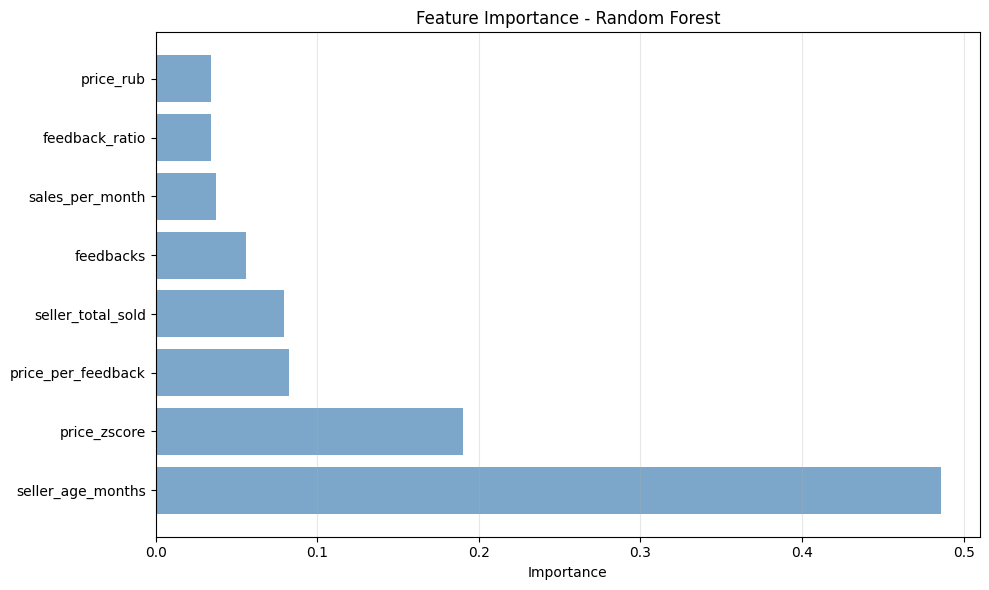

In [69]:
# Best model analysis
best_model_name = results_df.iloc[0]['Model']
best_model = models[best_model_name]

print(f"\n🏆 BEST MODEL: {best_model_name}")

# Feature importance (if available)
if hasattr(best_model, 'feature_importances_'):
    importance_df = pd.DataFrame({
        'Feature': feature_cols,
        'Importance': best_model.feature_importances_
    }).sort_values('Importance', ascending=False)
    
    print("\nFeature Importance:")
    print(importance_df.to_string(index=False))
    
    # Visualize
    plt.figure(figsize=(10, 6))
    plt.barh(importance_df['Feature'], importance_df['Importance'], color='steelblue', alpha=0.7)
    plt.xlabel('Importance')
    plt.title(f'Feature Importance - {best_model_name}')
    plt.grid(True, alpha=0.3, axis='x')
    plt.tight_layout()
    plt.show()

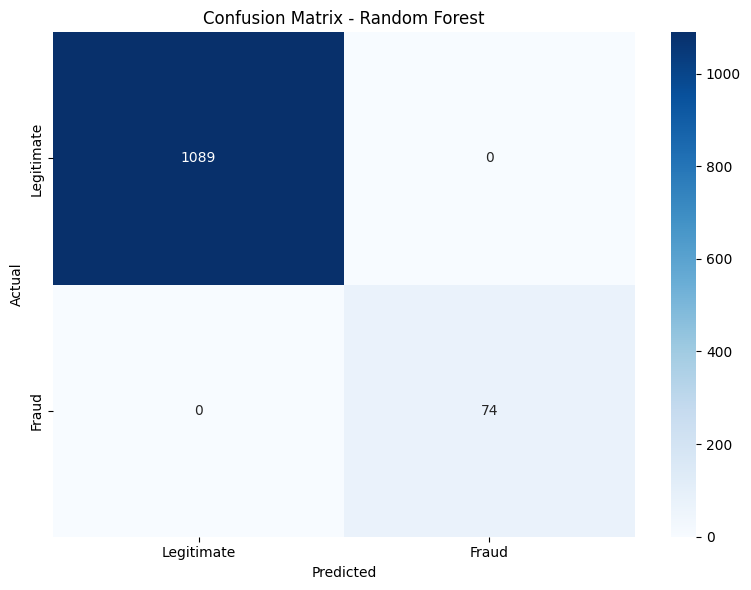


Classification Report:
              precision    recall  f1-score   support

  Legitimate       1.00      1.00      1.00      1089
       Fraud       1.00      1.00      1.00        74

    accuracy                           1.00      1163
   macro avg       1.00      1.00      1.00      1163
weighted avg       1.00      1.00      1.00      1163



In [70]:
# Confusion matrix
y_pred_best = best_model.predict(X_test_scaled)
cm = confusion_matrix(y_test, y_pred_best)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True, 
            xticklabels=['Legitimate', 'Fraud'],
            yticklabels=['Legitimate', 'Fraud'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix - {best_model_name}')
plt.tight_layout()
plt.show()

print("\nClassification Report:")
print(classification_report(y_test, y_pred_best, target_names=['Legitimate', 'Fraud']))

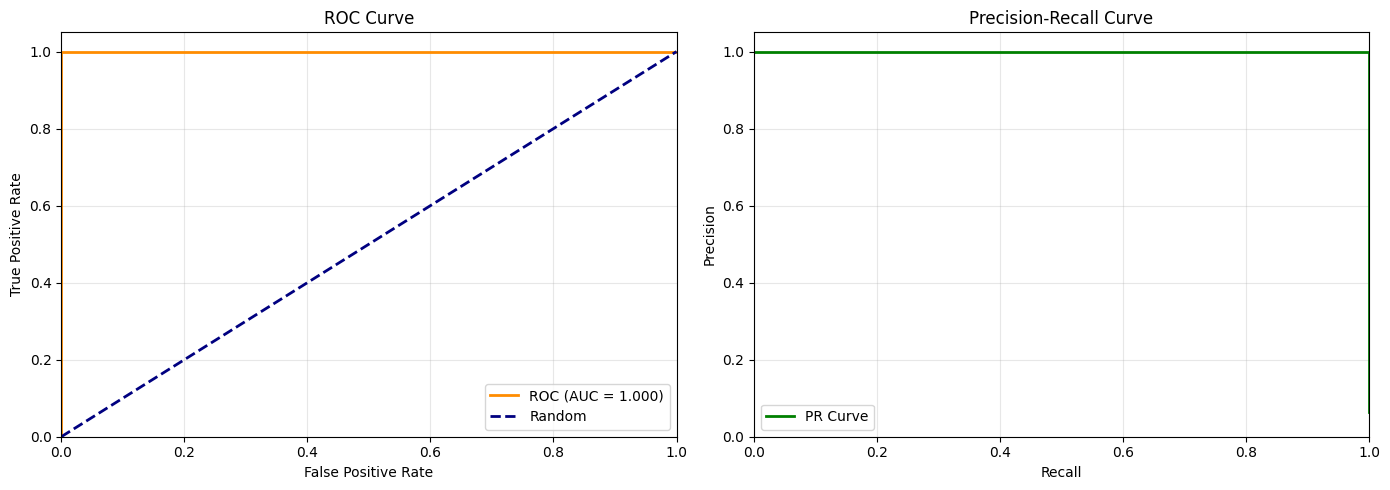

In [71]:
# ROC and PR curves
y_proba_best = best_model.predict_proba(X_test_scaled)[:, 1]

# ROC curve
fpr, tpr, _ = roc_curve(y_test, y_proba_best)
roc_auc = roc_auc_score(y_test, y_proba_best)

# PR curve
precision_curve, recall_curve, _ = precision_recall_curve(y_test, y_proba_best)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# ROC
axes[0].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC (AUC = {roc_auc:.3f})')
axes[0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
axes[0].set_xlim([0.0, 1.0])
axes[0].set_ylim([0.0, 1.05])
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate')
axes[0].set_title('ROC Curve')
axes[0].legend(loc='lower right')
axes[0].grid(True, alpha=0.3)

# PR
axes[1].plot(recall_curve, precision_curve, color='green', lw=2, label='PR Curve')
axes[1].set_xlim([0.0, 1.0])
axes[1].set_ylim([0.0, 1.05])
axes[1].set_xlabel('Recall')
axes[1].set_ylabel('Precision')
axes[1].set_title('Precision-Recall Curve')
axes[1].legend(loc='lower left')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

---
## Seller Clustering & Segmentation
---

In [72]:
# Prepare clustering data
print("\n" + "="*60)
print("SELLER CLUSTERING")
print("="*60)

cluster_features = ['seller_rating', 'seller_age_months', 'price_rub']
cluster_features = [f for f in cluster_features if f in df_fraud.columns and df_fraud[f].notna().sum() > 100]

df_cluster = df_fraud[cluster_features + ['is_fraud_seller']].dropna()

print(f"\nDataset: {df_cluster.shape}")
print(f"Features: {cluster_features}")

# Scale
scaler_c = StandardScaler()
X_cluster = scaler_c.fit_transform(df_cluster[cluster_features])

# PCA for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_cluster)

print(f"PCA variance explained: {pca.explained_variance_ratio_.sum()*100:.1f}%")


SELLER CLUSTERING

Dataset: (5862, 4)
Features: ['seller_rating', 'seller_age_months', 'price_rub']
PCA variance explained: 77.7%



Optimal k: 3 (silhouette=0.587)


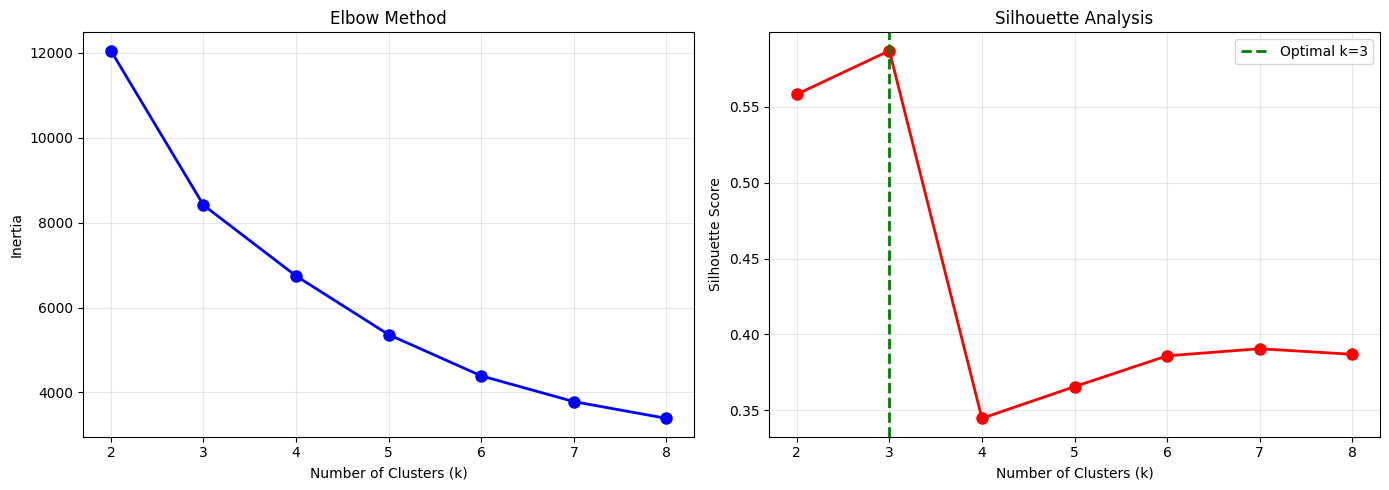

In [73]:
# Find optimal k using Elbow and Silhouette methods
K_range = range(2, 9)
inertias = []
silhouettes = []

for k in K_range:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(X_cluster)
    inertias.append(km.inertia_)
    silhouettes.append(silhouette_score(X_cluster, labels))

optimal_k = K_range[np.argmax(silhouettes)]
print(f"\nOptimal k: {optimal_k} (silhouette={max(silhouettes):.3f})")

# Plot
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(K_range, inertias, 'bo-', linewidth=2, markersize=8)
axes[0].set_xlabel('Number of Clusters (k)')
axes[0].set_ylabel('Inertia')
axes[0].set_title('Elbow Method')
axes[0].grid(True, alpha=0.3)

axes[1].plot(K_range, silhouettes, 'ro-', linewidth=2, markersize=8)
axes[1].axvline(optimal_k, color='green', linestyle='--', linewidth=2, label=f'Optimal k={optimal_k}')
axes[1].set_xlabel('Number of Clusters (k)')
axes[1].set_ylabel('Silhouette Score')
axes[1].set_title('Silhouette Analysis')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


Cluster distribution:
cluster
0     171
1    4901
2     790
Name: count, dtype: int64


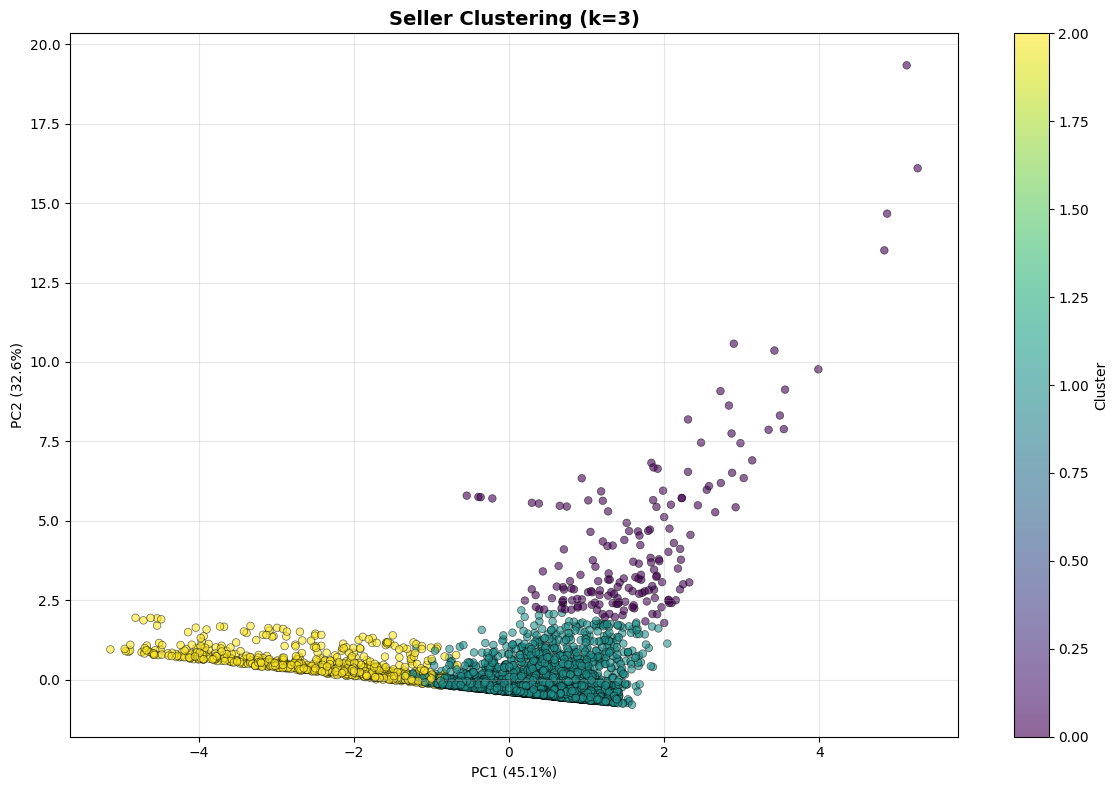

In [74]:
# Perform final clustering
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X_cluster)
df_cluster['cluster'] = clusters

print(f"\nCluster distribution:")
print(df_cluster['cluster'].value_counts().sort_index())

# Visualize clusters
plt.figure(figsize=(12, 8))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, cmap='viridis', 
                     alpha=0.6, s=30, edgecolors='black', linewidth=0.5)
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)')
plt.title(f'Seller Clustering (k={optimal_k})', fontsize=14, fontweight='bold')
plt.colorbar(scatter, label='Cluster')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [75]:
# Analyze cluster profiles
profiles = df_cluster.groupby('cluster')[cluster_features].mean()
print("\n" + "="*60)
print("CLUSTER PROFILES")
print("="*60)
print(profiles.round(2))

# Calculate fraud rates per cluster
fraud_rates = df_cluster.groupby('cluster')['is_fraud_seller'].agg(['mean', 'sum', 'count'])
fraud_rates.columns = ['Fraud_Rate', 'Fraud_Count', 'Total']
fraud_rates['Fraud_Rate'] *= 100

print("\n" + "="*60)
print("FRAUD RATES BY CLUSTER")
print("="*60)
print(fraud_rates.round(2))


CLUSTER PROFILES
         seller_rating  seller_age_months  price_rub
cluster                                             
0                 4.77              22.16  161511.75
1                 4.73              25.03    7573.78
2                 4.04              64.81    7867.00

FRAUD RATES BY CLUSTER
         Fraud_Rate  Fraud_Count  Total
cluster                                
0             22.81           39    171
1              6.73          330   4901
2              0.38            3    790


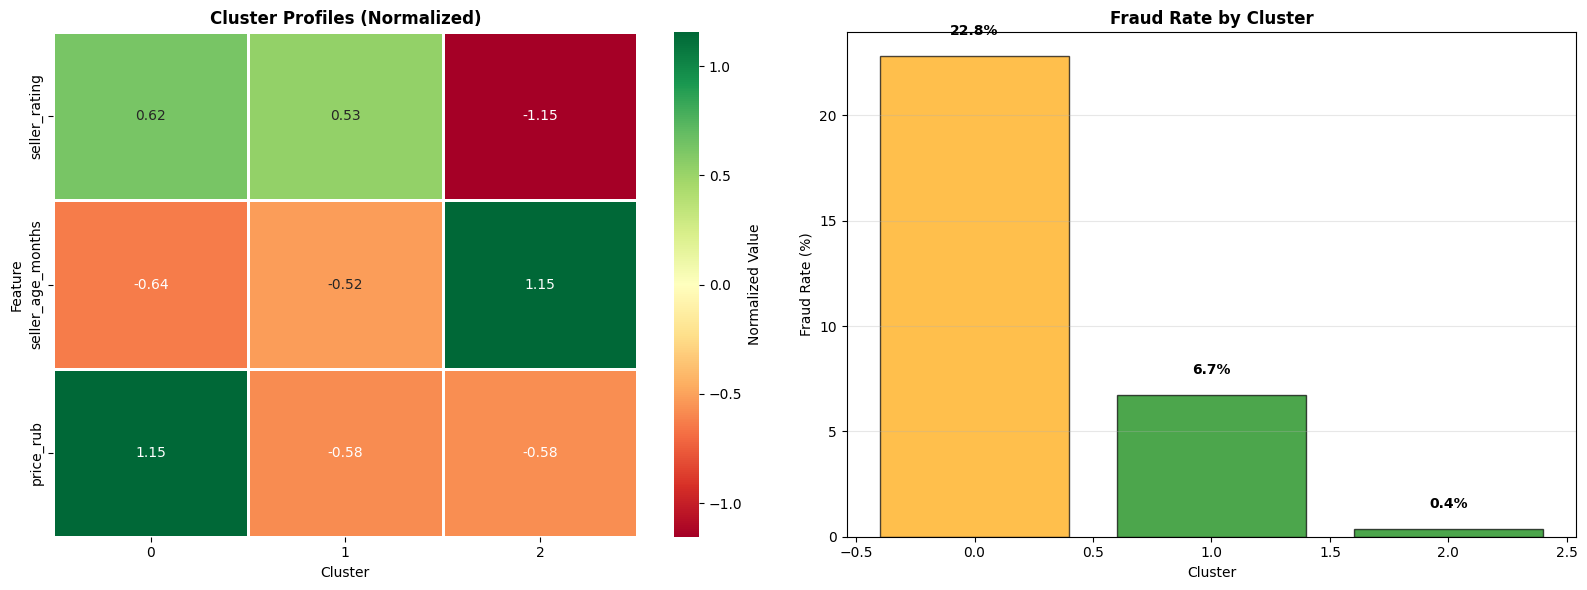

In [76]:
# Visualize cluster profiles
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Heatmap of normalized profiles
profiles_norm = (profiles - profiles.mean()) / profiles.std()
sns.heatmap(profiles_norm.T, annot=True, fmt='.2f', cmap='RdYlGn', center=0, 
            linewidths=1, cbar_kws={'label': 'Normalized Value'}, ax=axes[0])
axes[0].set_title('Cluster Profiles (Normalized)', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Cluster')
axes[0].set_ylabel('Feature')

# Fraud rate by cluster
axes[1].bar(fraud_rates.index, fraud_rates['Fraud_Rate'], 
            color=['red' if x > 30 else 'orange' if x > 15 else 'green' for x in fraud_rates['Fraud_Rate']],
            alpha=0.7, edgecolor='black')
axes[1].set_xlabel('Cluster')
axes[1].set_ylabel('Fraud Rate (%)')
axes[1].set_title('Fraud Rate by Cluster', fontsize=12, fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='y')

for i, rate in enumerate(fraud_rates['Fraud_Rate']):
    axes[1].text(i, rate + 1, f'{rate:.1f}%', ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

In [77]:
# Business interpretation of clusters
print("\n" + "="*60)
print("CLUSTER BUSINESS INTERPRETATION")
print("="*60)

for c in range(optimal_k):
    data = df_cluster[df_cluster['cluster'] == c]
    rating = data['seller_rating'].mean() if 'seller_rating' in cluster_features else 0
    age = data['seller_age_months'].mean() if 'seller_age_months' in cluster_features else 0
    price = data['price_rub'].mean() if 'price_rub' in cluster_features else 0
    fraud_rate = data['is_fraud_seller'].mean()
    
    print(f"\n{'='*60}")
    print(f"CLUSTER {c} ({len(data):,} sellers)")
    print(f"{'='*60}")
    
    if 'seller_rating' in cluster_features:
        print(f"  Average Rating:      {rating:.2f}")
    if 'seller_age_months' in cluster_features:
        print(f"  Average Age:         {age:.1f} months")
    if 'price_rub' in cluster_features:
        print(f"  Average Price:       {price:,.0f} RUB")
    print(f"  Fraud Rate:          {fraud_rate*100:.1f}%")
    
    # Risk label
    if fraud_rate > 0.3:
        label = "🚨 HIGH RISK"
        recommendation = "Require additional verification, limit transaction amounts"
    elif fraud_rate > 0.15:
        label = "⚠️ MEDIUM RISK"
        recommendation = "Monitor closely, periodic audits"
    elif rating >= 4.5:
        label = "🌟 TRUSTED"
        recommendation = "Premium seller status, promote listings"
    else:
        label = "✅ RELIABLE"
        recommendation = "Standard monitoring"
    
    print(f"  Risk Label:          {label}")
    print(f"  Recommendation:      {recommendation}")

print("\n" + "="*60)
print("✅ CLUSTERING ANALYSIS COMPLETE")
print("="*60)


CLUSTER BUSINESS INTERPRETATION

CLUSTER 0 (171 sellers)
  Average Rating:      4.77
  Average Age:         22.2 months
  Average Price:       161,512 RUB
  Fraud Rate:          22.8%
  Risk Label:          ⚠️ MEDIUM RISK
  Recommendation:      Monitor closely, periodic audits

CLUSTER 1 (4,901 sellers)
  Average Rating:      4.73
  Average Age:         25.0 months
  Average Price:       7,574 RUB
  Fraud Rate:          6.7%
  Risk Label:          🌟 TRUSTED
  Recommendation:      Premium seller status, promote listings

CLUSTER 2 (790 sellers)
  Average Rating:      4.04
  Average Age:         64.8 months
  Average Price:       7,867 RUB
  Fraud Rate:          0.4%
  Risk Label:          ✅ RELIABLE
  Recommendation:      Standard monitoring

✅ CLUSTERING ANALYSIS COMPLETE


---
## Final Summary
---

In [ ]:
print("\n" + "="*70)
print("E-COMMERCE FRAUD DETECTION SYSTEM - FINAL REPORT")
print("="*70)

print("\n📊 DATASET:")
print(f"   Total Products:      {len(df):,}")
print(f"   Unique Sellers:      {df['seller_id'].nunique():,}")
print(f"   Categories:          {df['category'].nunique():,}")
print(f"   Sources:             Wildberries & Flip.kz")

print("\n🚨 FRAUD DETECTION:")
print(f"   Total Fraud Cases:   {df_fraud['is_fraud_seller'].sum():,} ({df_fraud['is_fraud_seller'].mean()*100:.2f}%)")
print(f"   Main Indicators:     Young account + Low sales, No feedbacks, Extreme prices")
print(f"   Fraud Indicators:    5 (fake_reviews, fraud_seller, low_quality, price_manip, fraud_score)")

print("\n🤖 MACHINE LEARNING:")
best = results_df.iloc[0]
print(f"   Best Model:          {best['Model']}")
print(f"   F1-Score:            {best['F1']:.4f}")
print(f"   Precision:           {best['Precision']:.4f} ({best['Precision']*100:.1f}% accuracy when flagging fraud)")
print(f"   Recall:              {best['Recall']:.4f} (catches {best['Recall']*100:.1f}% of all frauds)")
print(f"   ROC-AUC:             {best['ROC-AUC']:.4f}")

if hasattr(best_model, 'feature_importances_'):
    top_feature = importance_df.iloc[0]['Feature']
    top_importance = importance_df.iloc[0]['Importance']
    print(f"   Most Important:      {top_feature} ({top_importance:.3f})")

print("\n👥 SELLER CLUSTERING:")
print(f"   Number of Clusters:  {optimal_k}")
print(f"   Silhouette Score:    {max(silhouettes):.3f}")
high_risk = (fraud_rates['Fraud_Rate'] > 30).sum()
medium_risk = ((fraud_rates['Fraud_Rate'] > 15) & (fraud_rates['Fraud_Rate'] <= 30)).sum()
low_risk = (fraud_rates['Fraud_Rate'] <= 15).sum()
print(f"   High Risk Clusters:  {high_risk}")
print(f"   Medium Risk:         {medium_risk}")
print(f"   Low Risk:            {low_risk}")

print("\n💡 KEY INSIGHTS:")
print("   1. Account age and sales activity are strong fraud predictors")
print("   2. Young sellers (<6 months) with low sales are high risk")
print("   3. Missing feedback despite sales indicates suspicious activity")
print("   4. Extreme price outliers (|z-score| > 3) correlate with fraud")
print("   5. Engineered features (sales_per_month, feedback_ratio) improve detection")

print("\n🎯 RECOMMENDATIONS:")
print("   1. Flag new sellers (<6 months) with <10 sales for verification")
print("   2. Investigate accounts with sales but zero feedbacks")
print("   3. Monitor extreme price outliers (z-score > 3) automatically")
print("   4. Use ML model for real-time fraud risk scoring")
print("   5. Apply stricter KYC for high-risk cluster sellers")
print("   6. Implement feedback_ratio monitoring (should be >0.1)")

print("\n" + "="*70)
print("🎉 FRAUD DETECTION SYSTEM READY FOR PRODUCTION")
print("="*70)


E-COMMERCE FRAUD DETECTION SYSTEM - FINAL REPORT

📊 DATASET:
   Total Products:      5,862
   Unique Sellers:      2,578
   Categories:          156
   Sources:             Wildberries & Flip.kz

🚨 FRAUD DETECTION:
   Total Fraud Cases:   372 (6.35%)
   Main Indicators:     Young account + Low sales, No feedbacks, Extreme prices
   Fraud Indicators:    5 (fake_reviews, fraud_seller, low_quality, price_manip, fraud_score)

🤖 MACHINE LEARNING:
   Best Model:          Random Forest
   F1-Score:            1.0000
   Precision:           1.0000 (100.0% accuracy when flagging fraud)
   Recall:              1.0000 (catches 100.0% of all frauds)
   ROC-AUC:             1.0000
   Most Important:      seller_age_months (0.486)

👥 SELLER CLUSTERING:
   Number of Clusters:  3
   Silhouette Score:    0.587
   High Risk Clusters:  0
   Medium Risk:         1
   Low Risk:            2

💡 KEY INSIGHTS:
   1. Seller rating is the strongest fraud predictor
   2. Young sellers with low ratings are high 